<a href="https://colab.research.google.com/github/mai0elkady/Boston_airbnb_data_analysis/blob/main/Boston_airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# to access the files I have
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import string 
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.patches import Patch
import matplotlib.colors as mcolors


In [3]:
#paths to my downloaded data
boston_airbnb_data_path = '/content/drive/MyDrive/UdacityND/project1/Boston_Airbnb/'
listings = pd.read_csv(boston_airbnb_data_path+'listings.csv')


Explore the dataset contains




In [4]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1,1,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,...,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,Apt has one more bedroom (which I use) and lar...,"If I am at home, I am likely working in my hom...",Pet friendly but please confirm with me if the...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,https://a1.muscache.com/im/pictures/39327812/d...,2572247,https://www.airbnb.com/users/show/2572247,Andrea,2012-06-07,"Boston, Massachusetts, United States",I live in Boston and I like to travel and have...,within an hour,100%,100%,f,https://a2.muscache.com/im/users/2572247/profi...,https://a2.muscache.com/im/users/2572247/profi...,Roslindale,1,1,"['email', 'phone', 'facebook', 'linkedin', 'am...",t,t,"Pinehurst Street, Boston, MA 02131, United States",Roslindale,Roslindale,...,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,$65.00,$400.00,NaN,$95.00,$10.00,0,$0.00,2,15,a week ago,NaN,26,54,84,359,2016-09-06,36,2014-06-01,2016-08-13,94.0,10.0,9.0,10.0,10.0,9.0,9.0,f,NaN,NaN,t,moderate,f,f,1

# Data Preprocessing

Manually remove some coloumns that are redundent or not important to my analysis

In [5]:
print(listings.columns)
#drop the coloumns below, either because they're not useful in our case, or will be correlated with other variables
smaller_listings = listings.drop(['zipcode','listing_url', 'scrape_id', 'last_scraped', 'name', 'summary','description', 'experiences_offered', 'neighborhood_overview',
       'notes','transit','access','interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name','host_location','host_picture_url', 'host_neighbourhood', 'host_verifications',
       'neighbourhood_group_cleansed', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact','calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped','first_review', 'last_review', 
       'requires_license',
       'license', 'jurisdiction_names','calculated_host_listings_count','space', 'host_about','host_thumbnail_url','street'
       ,'weekly_price','monthly_price','cleaning_fee','square_feet','security_deposit','extra_people','city','state',
       'id','host_listings_count','neighbourhood_cleansed','reviews_per_month','review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location'],axis = 1)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

I am instrested in the studying how the price changes and predicting it, so I will drop any row that has a missing price, and also I am dropping any row with more than 30% of the data missing

In [6]:
#drop rows with missing price
listings = listings.dropna(subset=['price'], axis=0)
#drop coloumns with more than 30% missing values
more_than_30 = listings.columns[listings.isnull().mean() > 0.3]
listings = listings.drop(more_than_30, axis=1)

In [7]:
pd.set_option('display.max_rows', None)
print("percent of missing values in each coloumn in listings")
display(smaller_listings.isnull().mean())


percent of missing values in each coloumn in listings


host_since                          0.000000
host_response_time                  0.131381
host_response_rate                  0.131381
host_acceptance_rate                0.131381
host_is_superhost                   0.000000
host_total_listings_count           0.000000
host_has_profile_pic                0.000000
host_identity_verified              0.000000
neighbourhood                       0.151464
property_type                       0.000837
room_type                           0.000000
accommodates                        0.000000
bathrooms                           0.003905
bedrooms                            0.002789
beds                                0.002510
bed_type                            0.000000
amenities                           0.000000
price                               0.000000
guests_included                     0.000000
minimum_nights                      0.000000
maximum_nights                      0.000000
number_of_reviews                   0.000000
review_sco

Check the type of each feature, and whether that makes sense or not

In [8]:
smaller_listings.dtypes
pd.set_option('display.max_rows', 10)

Price is an object even though it should be a float, let's check why?

In [9]:
smaller_listings['price']

0       $250.00
1        $65.00
2        $65.00
3        $75.00
4        $79.00
         ...   
3580     $69.00
3581    $150.00
3582    $198.00
3583     $65.00
3584     $65.00
Name: price, Length: 3585, dtype: object

It seems that there is a $ before each price, so we need to remove that

In [10]:
#we can remove the $ infront of the price and treat it as quatitative variable
#also remove the ,s in the price to convert it to float later
smaller_listings['price'] = smaller_listings['price'].map(lambda val: val.replace("$",'').replace(",",''), na_action = 'ignore')
smaller_listings = smaller_listings.astype({'price': 'float64'})

Plot the distribuition of the price to see if there are outliers

Text(0.5, 0, 'Prices')

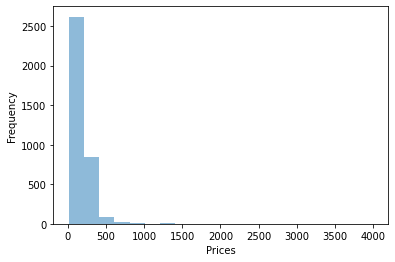

In [11]:
#histogram of price
ax = smaller_listings['price'].plot.hist(bins=20,alpha=0.5)
plt.xlabel("Prices")

We notice that there are extreme outliers that are not frequent, so it's better to remover these


In [12]:
print(smaller_listings.describe().price)
#drop prices not between the 5-95% quantile
len_before = len(smaller_listings)
smaller_listings = smaller_listings[smaller_listings['price'].between(smaller_listings['price'].quantile(.05), smaller_listings['price'].quantile(.95))]
len_after = len(smaller_listings)
print(smaller_listings.describe().price)
print("we dropped "+str(len_before-len_after)+" rows")

count    3585.000000
mean      173.925802
std       148.331321
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64
count    3232.000000
mean      159.166460
std        79.901999
min        50.000000
25%        90.000000
50%       150.000000
75%       208.000000
max       375.000000
Name: price, dtype: float64
we dropped 353 rows


Replot the price distribuition after dropping the outlier values

Text(0.5, 0, 'Prices')

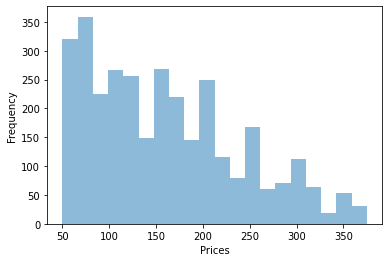

In [13]:
#histogram of price
ax = smaller_listings['price'].plot.hist(bins=20,alpha=0.5)
plt.xlabel("Prices")

Continuing with the other features, separate Quantitiative and Catagorical variables

In [14]:
#separate listings features into categorical and quantitative
cat_df = smaller_listings.select_dtypes(include=['object'])
quant_df = smaller_listings.select_dtypes(include=['float64','int64'])

host_response_rate and host acceptance rate ended up as a cat feature because it has % after it, so remove the %

In [15]:
#also host_response_rate	and host_acceptance_rate have % after them
quant_df['host_response_rate'] = cat_df['host_response_rate'].apply(lambda val: val[0:-1] if isinstance(val, float)==False else np.nan)
quant_df = quant_df.astype({'host_response_rate': 'float64'})
cat_df = cat_df.drop(['host_response_rate'],axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
#same for host acceptance rate
quant_df['host_acceptance_rate'] = cat_df['host_acceptance_rate'].apply(lambda val: val[0:-1] if isinstance(val, float)==False else np.nan)
quant_df = quant_df.astype({'host_acceptance_rate': 'float64'})
cat_df = cat_df.drop(['host_acceptance_rate'],axis = 1)

For the host_since variable, I want to calculate the number of years instead of using a date and change that to be a quantitative variable too

In [17]:
cat_df['host_since'] =  pd.to_datetime(cat_df['host_since'], format='%Y-%m-%d')
quant_df['host_since_days'] = cat_df['host_since'].apply(lambda val: (date(2021,1,7)-date(val.year,val.month,val.day)).days if val else NaN)
cat_df = cat_df.drop(['host_since'], axis = 1)

Change coloumns with strings t,f to boolean

In [18]:
#some coloumns have t,f for true and false, and I want to change them to boolean
for col in cat_df:
    if(len(cat_df[col].unique())<=3):
      unique_vals = sorted(cat_df[col].unique())
      if unique_vals[0] == 'f':
        cat_df[col] = cat_df[col].apply(lambda val: True if val=='t' else False)


Add a feature called amenties count, which counts the number of amenities offered by each listing

In [19]:
#change amenities to be amenties count instead
quant_df['amenities_count'] = cat_df.amenities.str.count(',')+1
cat_df = cat_df.drop('amenities', axis=1)

In [20]:
#reorganize the coloumns
quant_cols = quant_df.columns.tolist()
price_index = quant_cols.index('price')
#print(price_index) 
quant_cols = quant_cols[price_index+1:] + quant_cols[:price_index+1]
#print(quant_cols)
quant_df = quant_df[quant_cols]

plot the correlation with the quantitative features

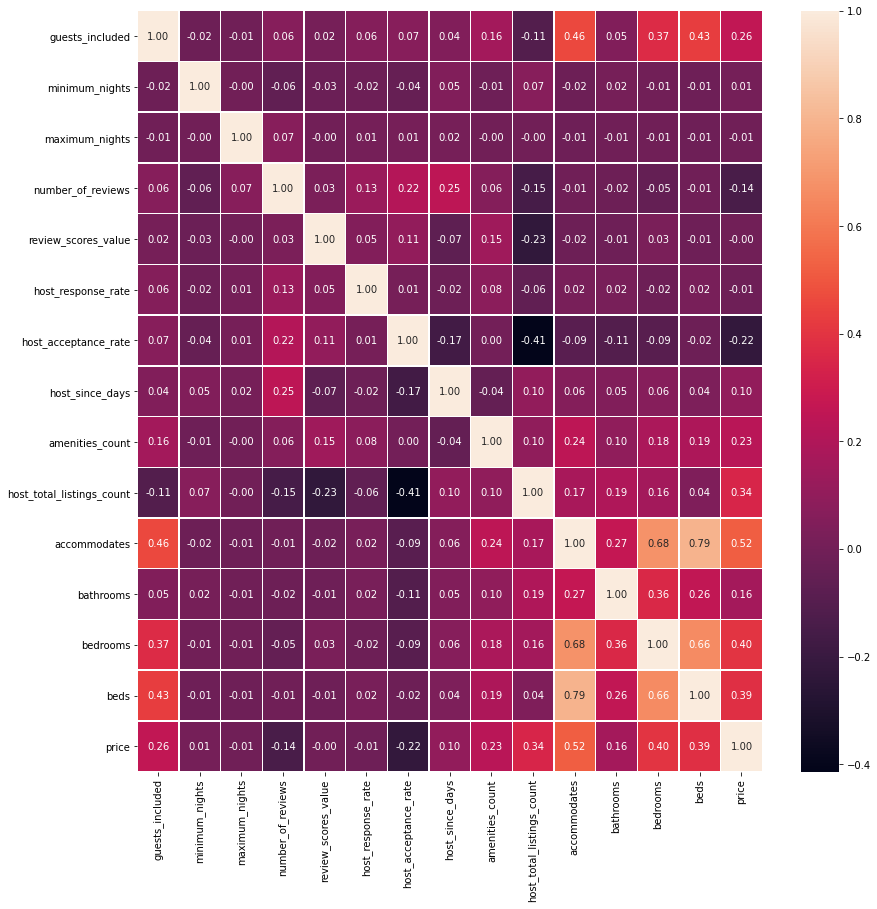

In [21]:
# with the quantitative variables plot a heat map to identify how are variable correlated
fig, ax = plt.subplots(figsize=(14,14))         # Sample figsize in inches
sns.heatmap(quant_df.corr(),annot=True,fmt=".2f",linewidths=.5, ax=ax)

We see some positive correlation between 'accommodates', 'bedrooms', 'beds' and price. Also, there is some positive correlation between 'amenities_count','host_total_listings_count','bathrooms', 'guests_included' and price.

In [22]:
cat_df_cols = list(cat_df.columns)
print("The categorical features are ")
print(cat_df.columns)
print("Length of cat_df is "+str(len(cat_df_cols)))

The categorical features are 
Index(['host_response_time', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood', 'property_type', 'room_type',
       'bed_type', 'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification'],
      dtype='object')
Length of cat_df is 12


In [23]:
quant_df.head()
quant_df_cols = list(quant_df.columns)
print("The quant features are ")
print(quant_df.columns)
print("Length of quant_df is "+str(len(quant_df_cols)))

The quant features are 
Index(['guests_included', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_value', 'host_response_rate',
       'host_acceptance_rate', 'host_since_days', 'amenities_count',
       'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price'],
      dtype='object')
Length of quant_df is 15


# A walk through Boston's neighborhoods

Plot the average price per neighbourhood and order it from lowest to highest

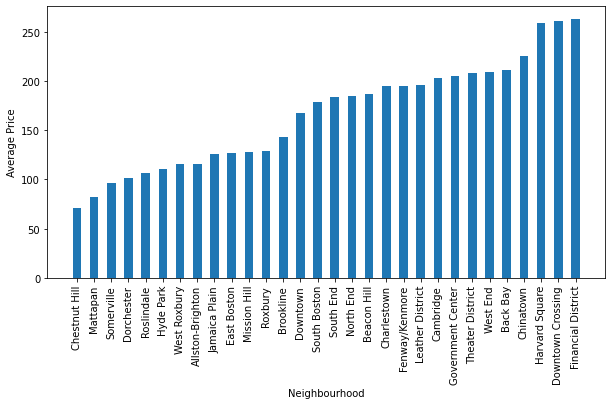

In [24]:
#average neighbourhood prices
neighbourhood_df = pd.DataFrame({'neighbourhood':cat_df['neighbourhood'],'price':quant_df['price']})
average_price_in_neighbourhood = neighbourhood_df.groupby('neighbourhood').mean().reset_index()
average_price_in_neighbourhood = average_price_in_neighbourhood.sort_values(by=['price'])
orderd_neighbourhoods = average_price_in_neighbourhood['neighbourhood'] #to be used in next cell
plt.figure(1,(10,5))
plt.bar(average_price_in_neighbourhood['neighbourhood'],average_price_in_neighbourhood['price'],width = 0.5);
plt.xlabel("Neighbourhood")
plt.ylabel("Average Price")
plt.xticks(rotation=90);


plot the neighbourhood vs average price for different room types and sort them the same way as before


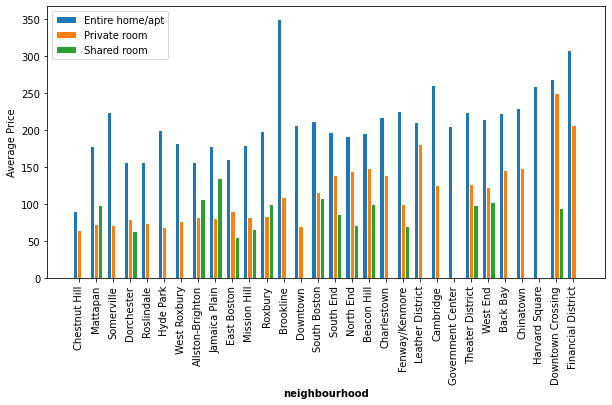

In [25]:
neighbourhood_roomtype_df = pd.DataFrame({'neighbourhood':cat_df['neighbourhood'],
                                          'room_type':cat_df['room_type'],'price':quant_df['price']})
neighbourhood_roomtype_df = neighbourhood_roomtype_df.sort_values(by=['price'])
average_price_neighbour_rmtype = neighbourhood_roomtype_df.groupby(['neighbourhood','room_type']).mean().reset_index()


barWidth = 0.25 # set width of bar
bars = []
labels = average_price_neighbour_rmtype['room_type'].unique()

neighbourhoods = average_price_neighbour_rmtype['neighbourhood'].unique()
i_s = len(neighbourhoods)
j_s = len(labels)
bars = np.ones((j_s,i_s))
for i,neighbourhood in enumerate(orderd_neighbourhoods):
  subset = average_price_neighbour_rmtype[average_price_neighbour_rmtype['neighbourhood'] == neighbourhood]
  for j,rm_type in enumerate(average_price_neighbour_rmtype['room_type'].unique()):
    if(rm_type in list(subset['room_type'])):
      bars[j][i] = subset[subset['room_type']==rm_type]['price']
    else:
      bars[j][i] = 0

rs = np.ones((len(labels),len(bars[0])))
rs[0,:] = np.arange(len(bars[0]))
plt.figure(3,(10,5))
for i in range(1,len(labels)):
  rs[i,:] = [x + barWidth for x in rs[i-1,:]]
colors = ['tab:blue','tab:orange','tab:green']
for i in range(0,len(labels)):
  plt.bar(rs[i,:], bars[i], color=colors[i], width=barWidth, edgecolor='white', label=labels[i])

plt.xlabel('neighbourhood', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars[0]))],list(orderd_neighbourhoods))
plt.ylabel("Average Price")
plt.legend()
plt.xticks(rotation=90);
plt.show()

#if we were to arrange them by entire home/private room/ etc. we would get a different plot than before

plot vertically the neighbourhood vs average price for different property types and sort them

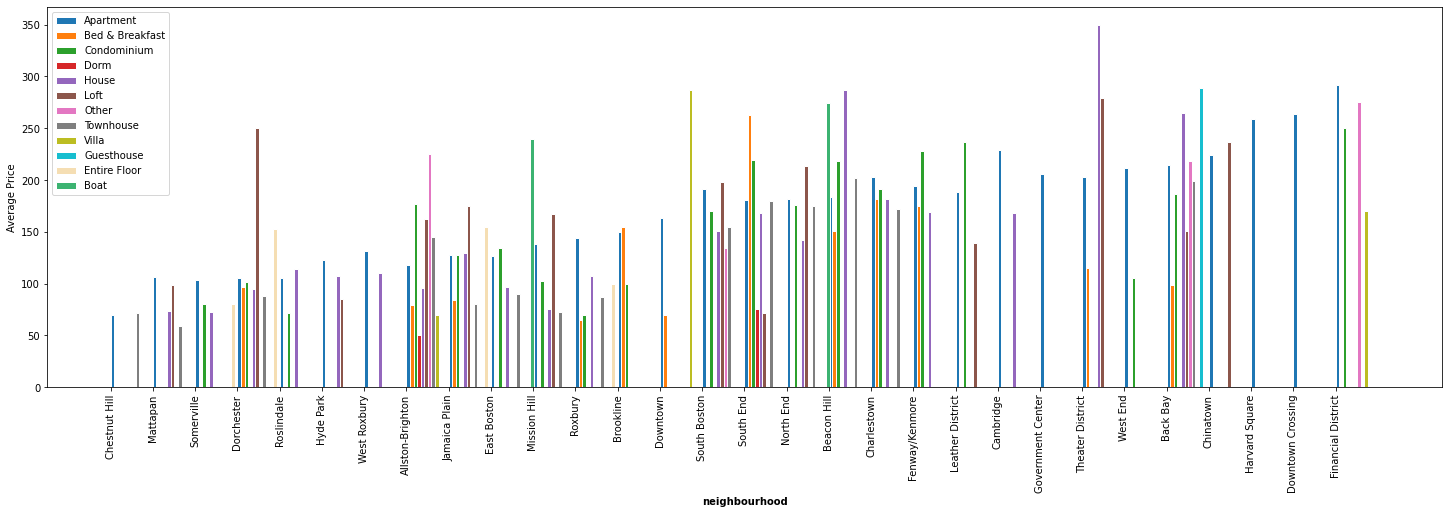

In [26]:
neighbourhood_roomtype_df = pd.DataFrame({'neighbourhood':cat_df['neighbourhood'],
                                          'property_type':cat_df['property_type'],'price':quant_df['price']})
neighbourhood_roomtype_df = neighbourhood_roomtype_df.sort_values(by=['price'])
average_price_neighbour_rmtype = neighbourhood_roomtype_df.groupby(['neighbourhood','property_type']).mean().reset_index()

# set width of bar
barWidth = 0.17
bars = []
labels = average_price_neighbour_rmtype['property_type'].unique()
# set height of bar
neighbourhoods = average_price_neighbour_rmtype['neighbourhood'].unique()
i_s = len(neighbourhoods)
j_s = len(labels)
bars = np.ones((j_s,i_s))
for i,neighbourhood in enumerate(orderd_neighbourhoods):
  subset = average_price_neighbour_rmtype[average_price_neighbour_rmtype['neighbourhood'] == neighbourhood]
  for j,rm_type in enumerate(average_price_neighbour_rmtype['property_type'].unique()):
    if(rm_type in list(subset['property_type'])):
      bars[j][i] = subset[subset['property_type']==rm_type]['price']
    else:
      bars[j][i] = 0

rs = np.ones((len(labels),len(bars[0])))
rs[0,:] = np.arange(len(bars[0]))*2

for i in range(1,len(labels)):
  rs[i,:] = [x + barWidth for x in rs[i-1,:]]
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','wheat','mediumseagreen']
plt.figure(4,(25,7))
for i in range(0,len(labels)):
  plt.bar(rs[i,:], bars[i], color=colors[i], width=barWidth, edgecolor='white', label=labels[i],align='edge')

plt.xlabel('neighbourhood', fontweight='bold')
plt.xticks([r*2 for r in range(len(bars[0]))],list(orderd_neighbourhoods))
plt.ylabel("Average Price")
plt.legend()
plt.xticks(rotation=90);
plt.show()


This plot has too much information, would it be better if we plot it horizontally

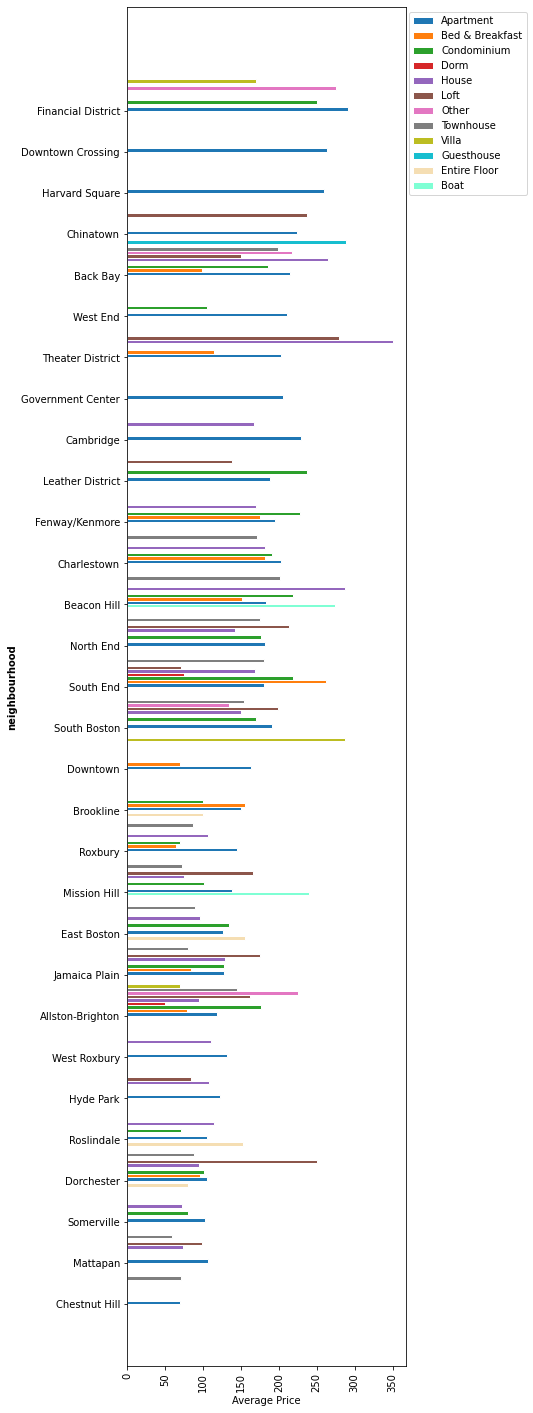

In [27]:
#plot horizontally the neighbourhood vs average price for different property types and sort them

neighbourhood_roomtype_df = pd.DataFrame({'neighbourhood':cat_df['neighbourhood'],
                                          'property_type':cat_df['property_type'],'price':quant_df['price']})
neighbourhood_roomtype_df = neighbourhood_roomtype_df.sort_values(by=['price'])
average_price_neighbour_rmtype = neighbourhood_roomtype_df.groupby(['neighbourhood','property_type']).mean().reset_index()

# set width of bar
barWidth = 0.17
bars = []
labels = average_price_neighbour_rmtype['property_type'].unique()
# set height of bar
neighbourhoods = average_price_neighbour_rmtype['neighbourhood'].unique()
i_s = len(neighbourhoods)
j_s = len(labels)
bars = np.ones((j_s,i_s))
for i,neighbourhood in enumerate(orderd_neighbourhoods):
  subset = average_price_neighbour_rmtype[average_price_neighbour_rmtype['neighbourhood'] == neighbourhood]
  for j,rm_type in enumerate(average_price_neighbour_rmtype['property_type'].unique()):
    if(rm_type in list(subset['property_type'])):
      bars[j][i] = subset[subset['property_type']==rm_type]['price']
    else:
      bars[j][i] = 0
    

# Set position of bar on X axis
rs = np.ones((len(labels),len(bars[0])))
rs[0,:] = np.arange(len(bars[0]))*2

for i in range(1,len(labels)):
  rs[i,:] = [x + barWidth for x in rs[i-1,:]]
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','wheat','aquamarine']
plt.figure(4,(5,25))
for i in range(0,len(labels)):
  plt.barh(rs[i,:], bars[i], color=colors[i], height=barWidth, edgecolor='white', label=labels[i],align='edge')

plt.ylabel('neighbourhood', fontweight='bold')
plt.yticks([r*2  for r in range(len(bars[0]))],list(orderd_neighbourhoods))
plt.xlabel("Average Price")
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1))
plt.xticks(rotation=90);
plt.show()


Still the plot has a lot of information, let's plot every property type separetly

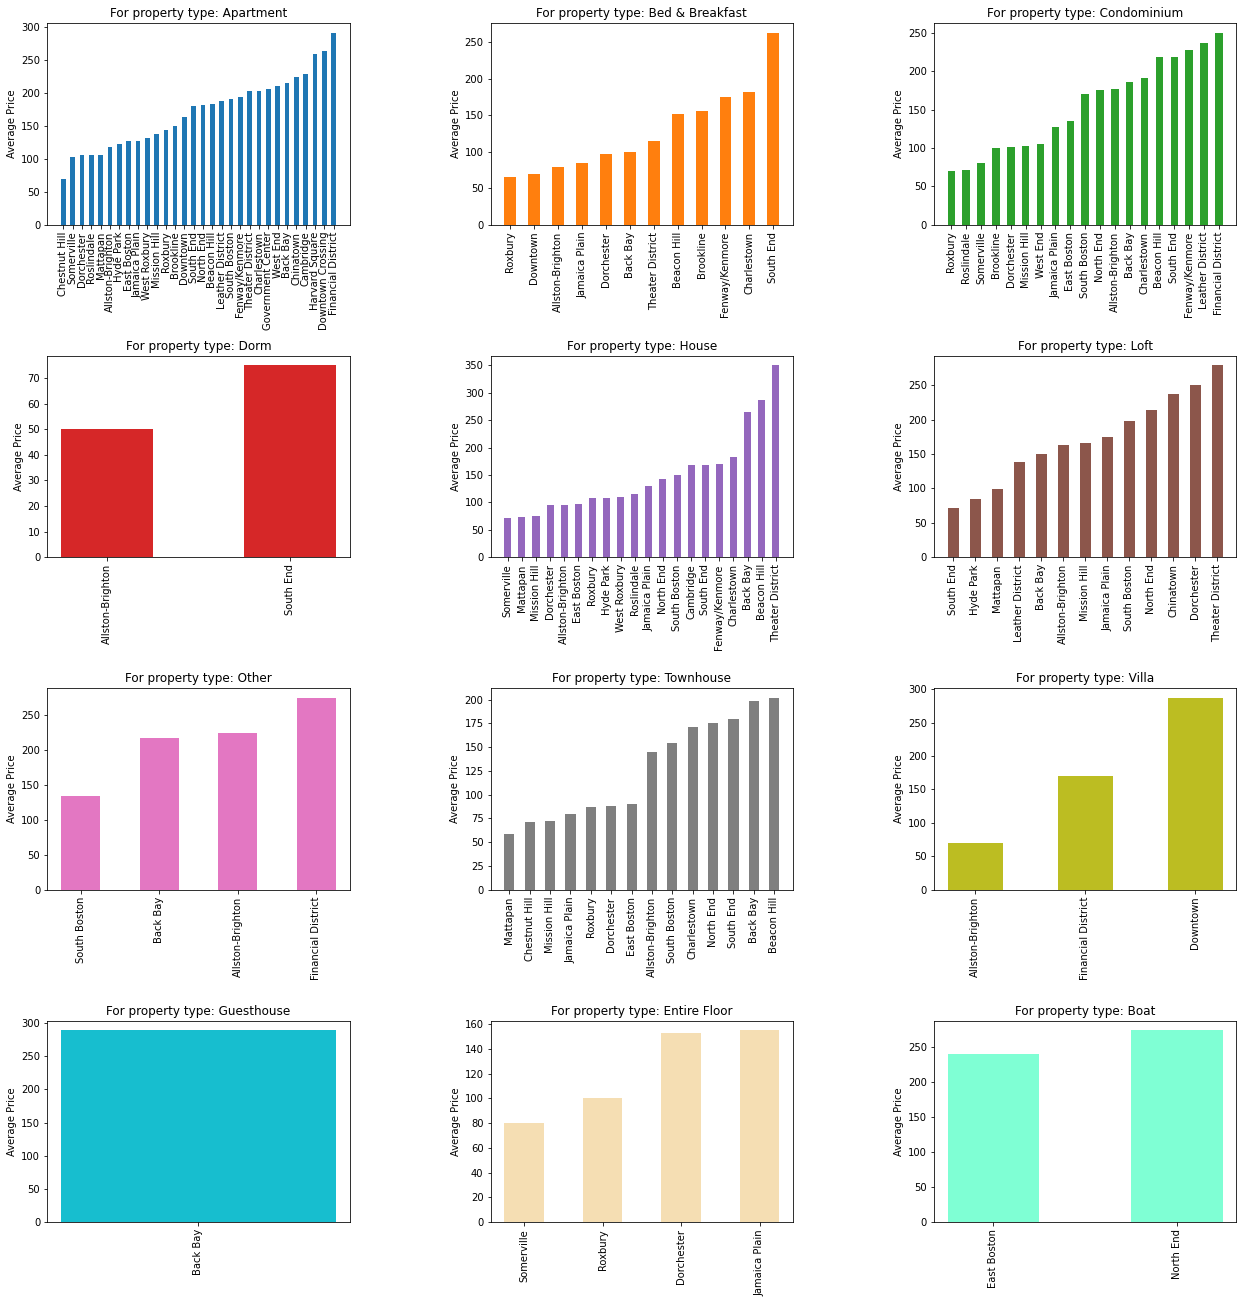

In [28]:
# plot different bar plots for each property type and the neighbourhood 
# and sort the average prices

fig, axs = plt.subplots(4, 3,figsize=(20,20))
fig.tight_layout(pad=11)
for i,prop in enumerate(labels):
  prop_type_df = average_price_neighbour_rmtype[average_price_neighbour_rmtype['property_type']==prop]
  average_price_in_prop_type_df = prop_type_df.groupby('neighbourhood').mean().reset_index()
  average_price_in_prop_type_df = average_price_in_prop_type_df.sort_values(by=['price'])
  plt.sca(axs[i//3,i%3])
  if len(np.unique(average_price_in_prop_type_df['neighbourhood']))>10:
    barWidth = 0.01
  else:
    barwidth = 0.1
  axs[i//3,i%3].bar(average_price_in_prop_type_df['neighbourhood'],average_price_in_prop_type_df['price'],width = 0.5,color=colors[i]);

  plt.ylabel("Average Price")
  plt.title("For property type: "+prop)
  plt.xticks(rotation=90);

# A walkthrough Models to predict Airbnb prices in Boston

In [29]:
def get_training_data(cat_df,quant_df,impute,dummies):
  '''
  preprocess the catecorical and quantitative features to obtain the training data
  cat_df: categorical features
  quant_df: Quanitative features including the price
  impute: binary value, whether to impute missing values by the coloumn mean or drop them
  dummies: binary value, whether to code missing values as a dummy variable in categrical features or code it as 0
  '''
  cat_df_with_dummies = pd.get_dummies(cat_df,dummy_na=dummies)
  all_data = pd.merge(cat_df_with_dummies,quant_df, left_index=True, right_index=True)
  #print(len(list(cat_df_with_dummies.columns)))
  #print(len(list(quant_df.columns)))
  n,d = len(all_data), len(all_data.columns)
  if(impute==0):
    all_data_no_na = all_data.dropna(axis=0,how='any')
    print(str(n-len(all_data_no_na))+" rows that contain missing values were dropped")
  else:
    fill_mean = lambda col: col.fillna(col.mean())
    all_data_no_na = all_data.apply(fill_mean,axis = 0)
  y = all_data_no_na['price']
  X = all_data_no_na.drop(columns=['price'])
  
  return X,y,all_data
X,y,all_data = get_training_data(cat_df,quant_df,impute = 0,dummies=True) #first try with dropping rows with missing values

918 rows that contain missing values were dropped


In [30]:
print("Number of samples available with no imputation is: "+str(X.shape[0]))

Number of samples available with no imputation is: 2314


In [31]:
def scatter_plot_true_vs_pred(y_pred,y_true,ind,axs):
  '''
  plot a scatter plot of the true vs predicted values for the price
  y_pred: predicted price value
  y_true: actual price value
  ind: the index of the subplot
  axs: the axis of the subplot
  '''
  if(ind!=4):
    plt.sca(axs[ind//2,ind%2])
    plt.scatter(y_true, y_pred, c='crimson')
    p1 = max(max(y_pred), max(y_true))
    p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
  #plt.show()

## Linear regression with no imputation

In [32]:
def linear_reg_training(X,y,random_seed,n_splits):
  '''
  Train a linear regression model on X and y for different values of alpha
  
  Inputs:
  X: data with dimensions nxd 
  y: prices
  random_seed: an int used to insure reprodusable results
  n_splits: an int, which is the number of different times we want to split the data in different ways, and average our
  results across those splits
  '''
  np.random.seed(random_seed)
  
  random_ints =  np.random.randint(low=0,high=100,size=n_splits)
  total_r2_score = 0
  rss = 0
  diff = 0
  fig, axs = plt.subplots(2, 2,figsize=(10,10))
  fig.tight_layout(pad =5)
  for i,rand_int in enumerate(random_ints):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_int)
    clf = LinearRegression().fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    #replace the predicted negative value with the minimum value in y_train
    neg_values = np.where(y_pred<0)
    y_pred[neg_values] = np.min(y_train)
    scatter_plot_true_vs_pred(y_pred,y_test,i,axs)
    total_r2_score += r2_score(y_test, y_pred)
    abs_diff = np.abs(y_pred-y_test)
    diff += sum((abs_diff/y_test)*100)
    rss += sum((y_pred-y_test)**2)
  avg_r2_score = total_r2_score/n_splits
  avg_diff = diff/n_splits  
  return avg_r2_score,avg_diff

Average R2 score was 0.6753895168983158 average diff in percentage is 17500.724610946192


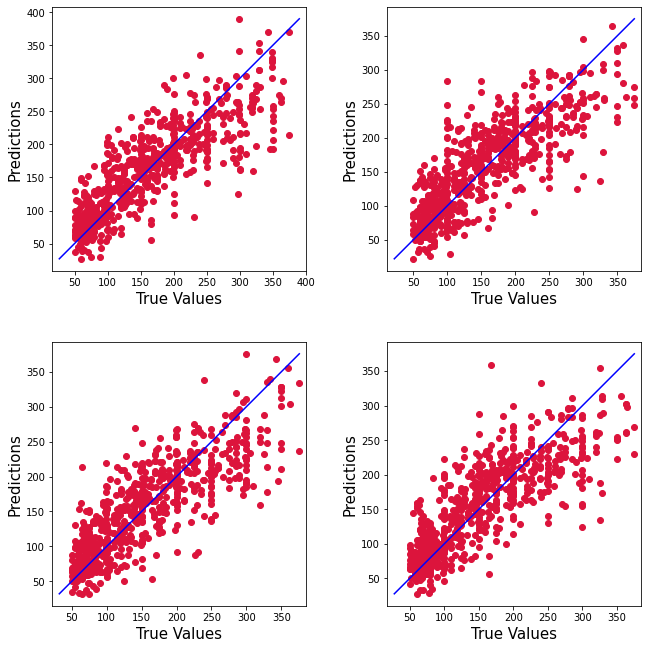

In [33]:
avg_r2_score,avg_diff = linear_reg_training(X,y,random_seed=42,n_splits=5)
print("Average R2 score was "+str(avg_r2_score)+" average diff in percentage is "+str(avg_diff))

## Ridge regression with no imputation

In [34]:
def ridge_reg_training(X,y,alphas,random_seed,n_splits):
  '''
  Train a ridge regression model on X and y for different values of alpha
  
  Inputs:
  X: data with dimensions nxd 
  y: prices
  alphas: a list of different values for the regularization paramter
  random_seed: an int used to insure reprodusable results
  n_splits: an int, which is the number of different times we want to split the data in different ways, and average our
  results across those splits
  '''
  np.random.seed(random_seed)
  random_ints =  np.random.randint(low=0,high=100,size=n_splits)
  avg_acc_scores = []
  avg_rss = []
  avg_diff = []
  avg_r2_scores = []
  for alpha in alphas:
    total_acc_score = 0
    total_r2_score = 0
    rss = 0
    diff = 0
    for rand_int in random_ints:
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rand_int)
      clf = Ridge(alpha=alpha).fit(X_train,y_train)
      y_pred = clf.predict(X_test)
      #replace the predicted negative value with the minimum value in y_train
      neg_values = np.where(y_pred<=0)
      y_pred[neg_values] = np.min(y_train)
      #scatter_plot_true_vs_pred(y_pred,y_test)
      abs_diff = np.abs(y_pred-y_test)
      diff += sum((abs_diff/y_test)*100)
      rss += sum((y_pred-y_test)**2)
      total_acc_score += clf.score(X_test, y_test)
      total_r2_score += r2_score(y_test, y_pred)
    avg_acc_score = total_acc_score/n_splits
    avg_r2_scores.append(total_r2_score/n_splits)
    avg_acc_scores.append(avg_acc_score)
    avg_rss.append(rss/n_splits)
    avg_diff.append(diff/n_splits)

  return avg_r2_scores,avg_rss,avg_diff


In [35]:
def plot_r2_vs_alphas(avg_r2_scores,alphas):
  '''
  plot the average r2 scores vs alphas
  '''
  plt.figure()
  plt.plot(alphas,avg_r2_scores,'b.-')
  plt.xlabel("Alpha Values")
  plt.ylabel("Average R2 Scores")
  

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00061e-20): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00061e-20): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00059e-20): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00042e-19): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00049e-19): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAl

Avg R2 score for alpha = 1 is 0.6778656551177532


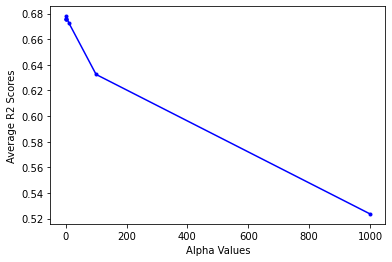

In [36]:
alphas = [0.0001 ,0.001, 0.1, 1, 10, 100, 1000] #try different values of alpha
random_seed = 42
n_splits = 5
avg_r2_scores, avg_rss, avg_diff = ridge_reg_training(X,y,alphas,random_seed,n_splits)
plot_r2_vs_alphas(avg_r2_scores,alphas)
max_index = np.argmax(avg_r2_scores)
print("Avg R2 score for alpha = "+str(alphas[max_index])+" is "+str(avg_r2_scores[max_index]))

Both linear regression and ridge regression have comparable average R2 values

## linear regression with imputation

Now we repeat the same analysis but this time we impute the data and see how that affects the R2 values

In [37]:
X,y,all_data = get_training_data(cat_df,quant_df,impute=1,dummies=True)
print("Number of samples available after imputation is: "+str(X.shape[0]))

Number of samples available after imputation is: 3232


Average R2 score was 0.6091724852588009 average diff in percentage is 26452.493067068845


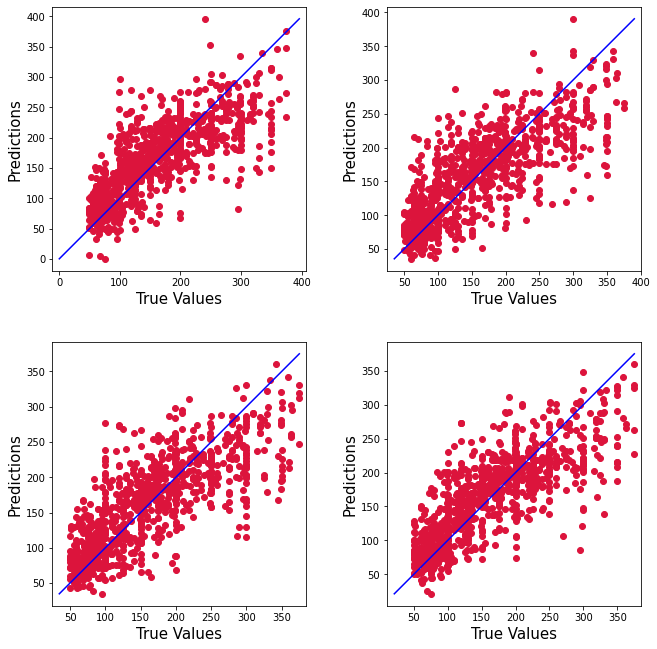

In [38]:
#first for linear regression
avg_r2_score,avg_diff = linear_reg_training(X,y,random_seed=42,n_splits=5)
print("Average R2 score was "+str(avg_r2_score)+" average diff in percentage is "+str(avg_diff))

## ridge regression with imputation

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00044e-20): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00045e-20): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00044e-20): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00037e-19): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.00041e-19): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAl

Avg R2 score for alpha = 1 is 0.6130302591162371


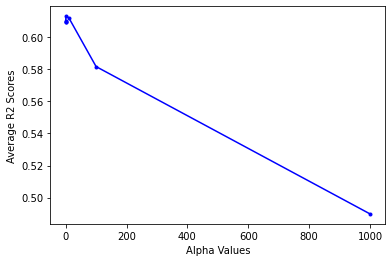

In [39]:
#second for ridge regression
avg_r2_scores, avg_rss, avg_diff = ridge_reg_training(X,y,alphas,random_seed,n_splits)
plot_r2_vs_alphas(avg_r2_scores,alphas)
max_index = np.argmax(avg_r2_scores)
print("Avg R2 score for alpha = "+str(alphas[max_index])+" is "+str(avg_r2_scores[max_index]))

Imputing doesn't help us achieve higher R2 values, so for our case, it's better to drop the rows containing missing values

# A walkthrough potential factors that affect the listing price

For the linear regression model, let's see the weights asociated with the coefficients. 

In [40]:
def plot_coefs(X,y,feature_names,s1,s2,threshold=None):
  '''
  Use all data in X and y to train a linear regression model, and extract the coefficients of the linear model
  feature_names: names of the features in X
  s1,s2: size of the plot
  threshold: if None then plot all features and their corresponding coefficients
             if +ve plot all features that have coefficients above the threshold
             if -ve plot all features that have coefficients below the threshold
  '''
  random_seed = 42
  clf = LinearRegression().fit(X,y)
  y_pred = clf.predict(X)
  #replace the predicted negative value with the minimum value in y_train
  neg_values = np.where(y_pred<0)
  y_pred[neg_values] = np.min(y)
  total_r2_score = r2_score(y, y_pred)
  #extract the coefficients 
  coefs = clf.coef_
  
  names = []
  for i,feature_name in enumerate(feature_names):
    names.append(str(i)+": "+feature_name)
  plt.figure()
  data = {'names':names, 'coef_values': coefs}
  
  plot_df = pd.DataFrame(data)
  if(threshold!=None):
    if(threshold>0):
      plot_df = plot_df[plot_df['coef_values']>threshold]
    else:
      plot_df = plot_df[plot_df['coef_values']<threshold]
    #plot_df = plot_df.reset_index()
  # from https://stackoverflow.com/questions/62941033/how-to-turn-x-axis-values-into-a-legend-for-matplotlib-bar-graph
  # create a color palette the length of the dataframe
  colors = sns.color_palette("husl",n_colors=len(plot_df))
  plt.figure(figsize=(s1,s2))
  # plot
  p = sns.barplot(x=plot_df.index, y='coef_values', data=plot_df, palette=colors)

  # create color map with colors and df.names
  cmap = dict(zip(plot_df['names'], colors))

  # create the rectangles for the legend
  patches = [Patch(color=v, label=k) for k, v in cmap.items()]

  # add the legend
  plt.legend(handles=patches, bbox_to_anchor=(1.04, 0.5), loc='center left', borderaxespad=0);
 


918 rows that contain missing values were dropped


<Figure size 432x288 with 0 Axes>

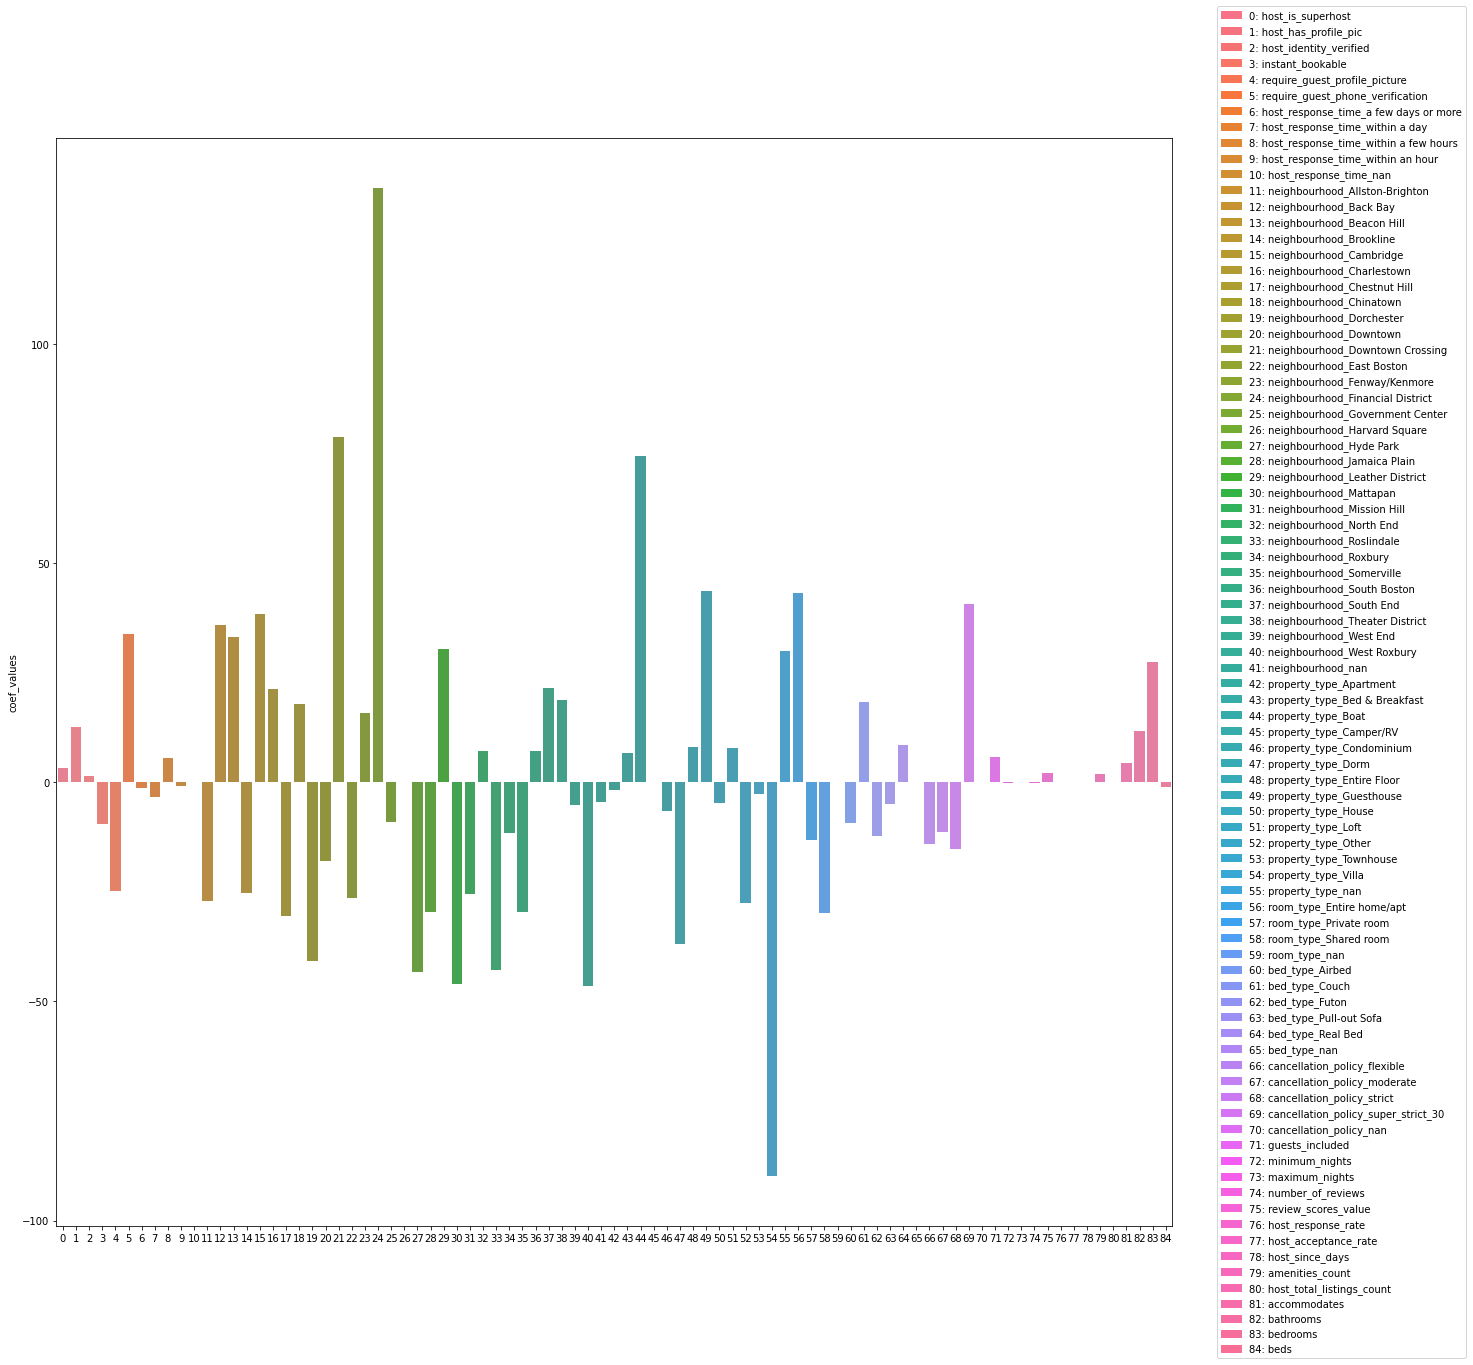

In [41]:
X,y,all_data = get_training_data(cat_df,quant_df,impute = 0,dummies=True)
feature_names = all_data.drop(['price'],axis = 1).columns
plot_coefs(X,y,feature_names,20,20)

This contains too much information, so let's only extract the features with the highest coefficients (where coef>25)

<Figure size 432x288 with 0 Axes>

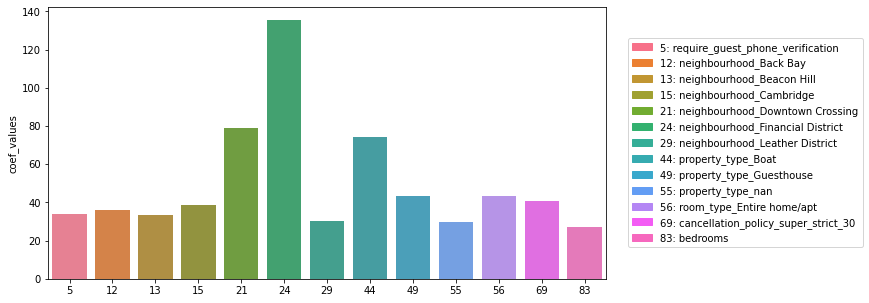

In [42]:
#plot most +ve coefficients
plot_coefs(X,y,feature_names,threshold=25,s1=10,s2=5)

According to these analysis, Having a property in Back Bay, Beacon Hill, Cambridge, Downtown Crossing, the Financial District, or the Leather District, and if you're property type is a Boat or a guest house, and of course if you're renting an entire room/apartement and have more bedrooms, will have more impact on the price you charge compared to other factors. 

<Figure size 432x288 with 0 Axes>

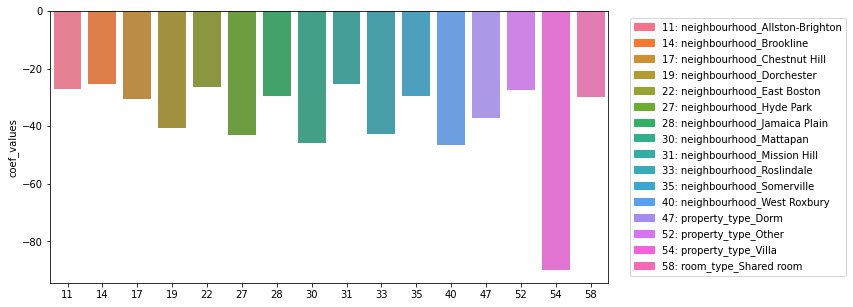

In [43]:
#plot most -ve coefficients
plot_coefs(X,y,feature_names,threshold=-25,s1=10,s2=5)